In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pygmt
from gprm.datasets import Reconstructions
from gprm.utils.raster import to_anchor_plate
from gprm.datasets import Paleogeography


In [2]:
# Load the Scotese rotation model and raster series from remote repositories
ScoteseModel = Reconstructions.fetch_Scotese() 

# NB here the resolution can either be '06m' or '01d'
raster_list = Paleogeography.fetch_Paleomap(resolution='06m')

# generally the input grids will have been created with anchor plate = 0, and you want to transform
# them into a different plateid frame (could be another reference frame, or fixing an actual plate)
raster_original_plate_id = 0

# For this example we rotate raster to fixed South America coo
plate_id_to_rotate_to = 201

reconstruction_time = 105.


grdimage [WARNING]: Guessing of registration in conflict between x and y, using gridline


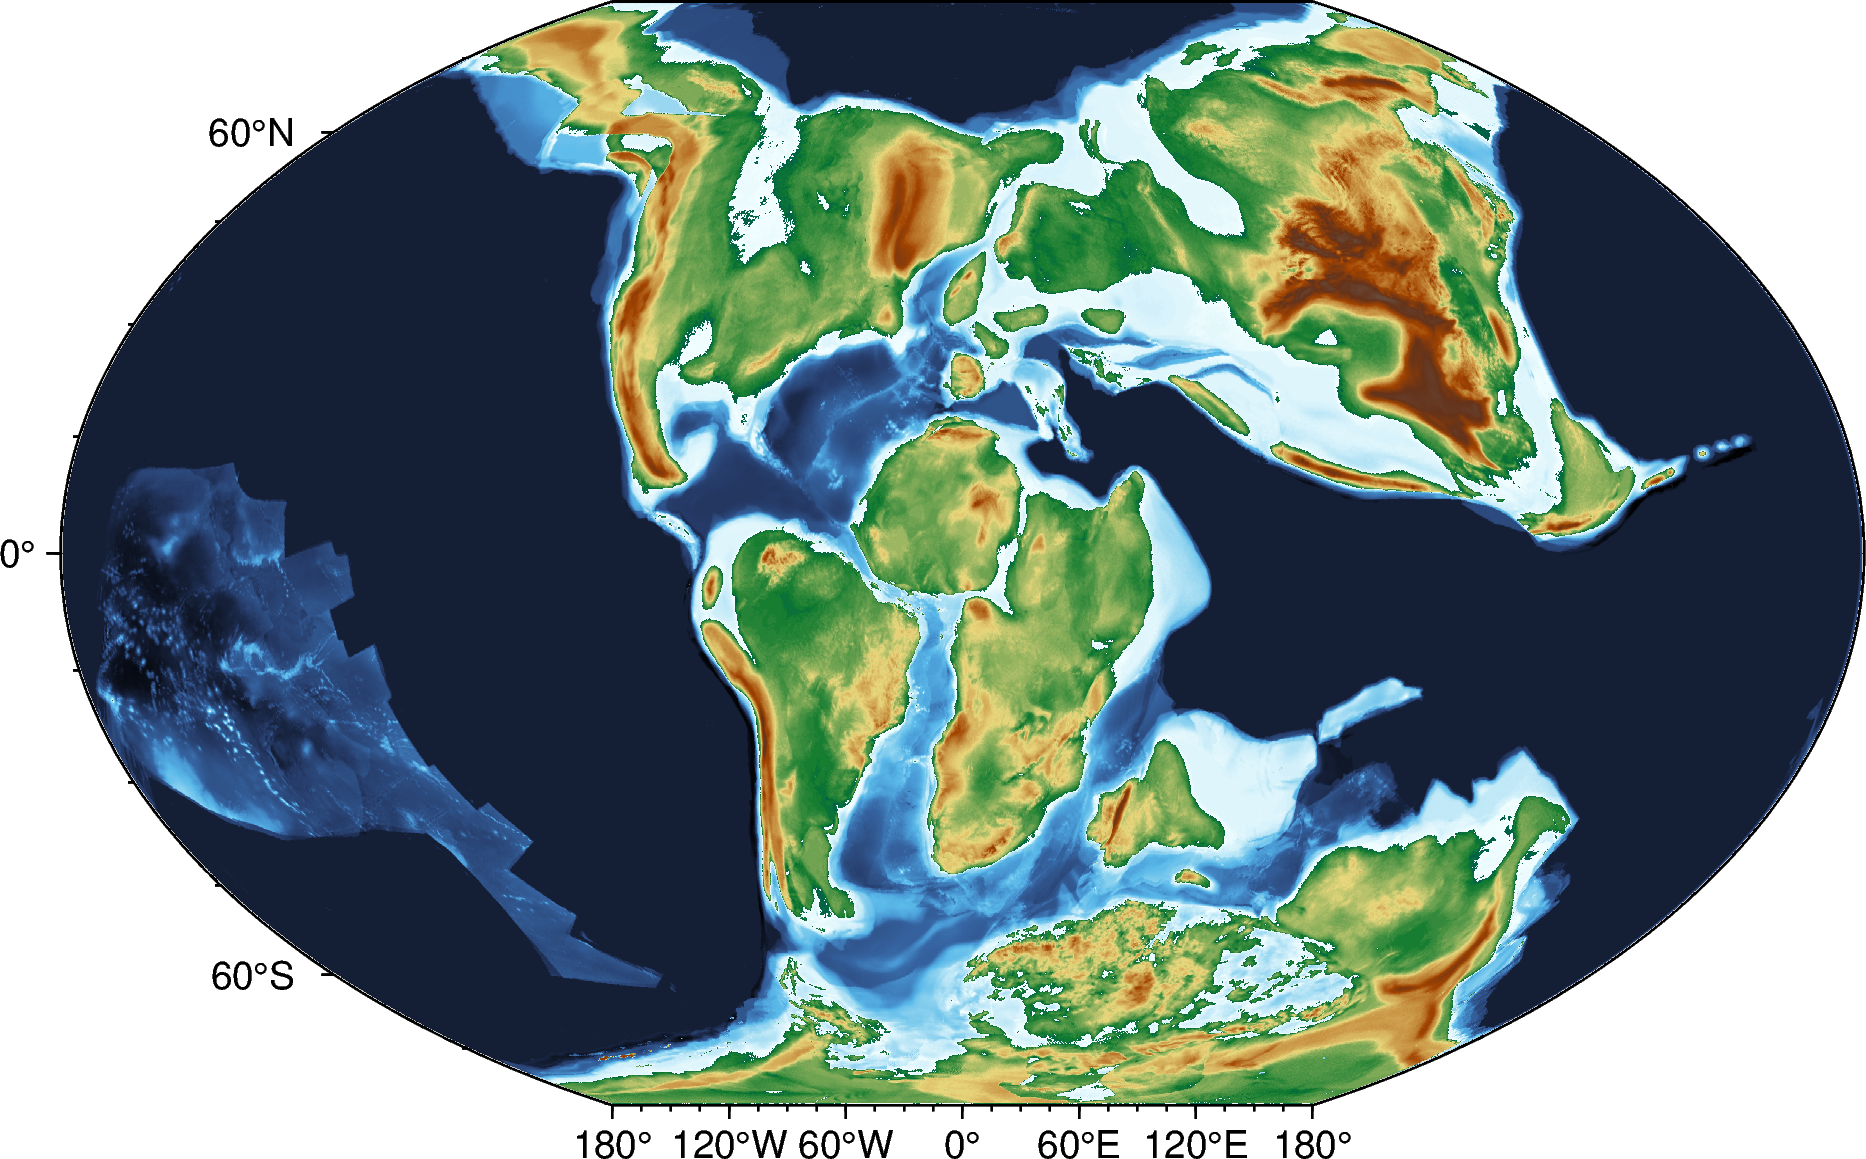

In [3]:
fig = pygmt.Figure()
fig.basemap(projection='R6i', region='d', frame='afg')
fig.grdimage(grid=raster_list[reconstruction_time], cmap='geo')
fig.show()

grdinfo [WARNING]: Guessing of registration in conflict between x and y, using gridline


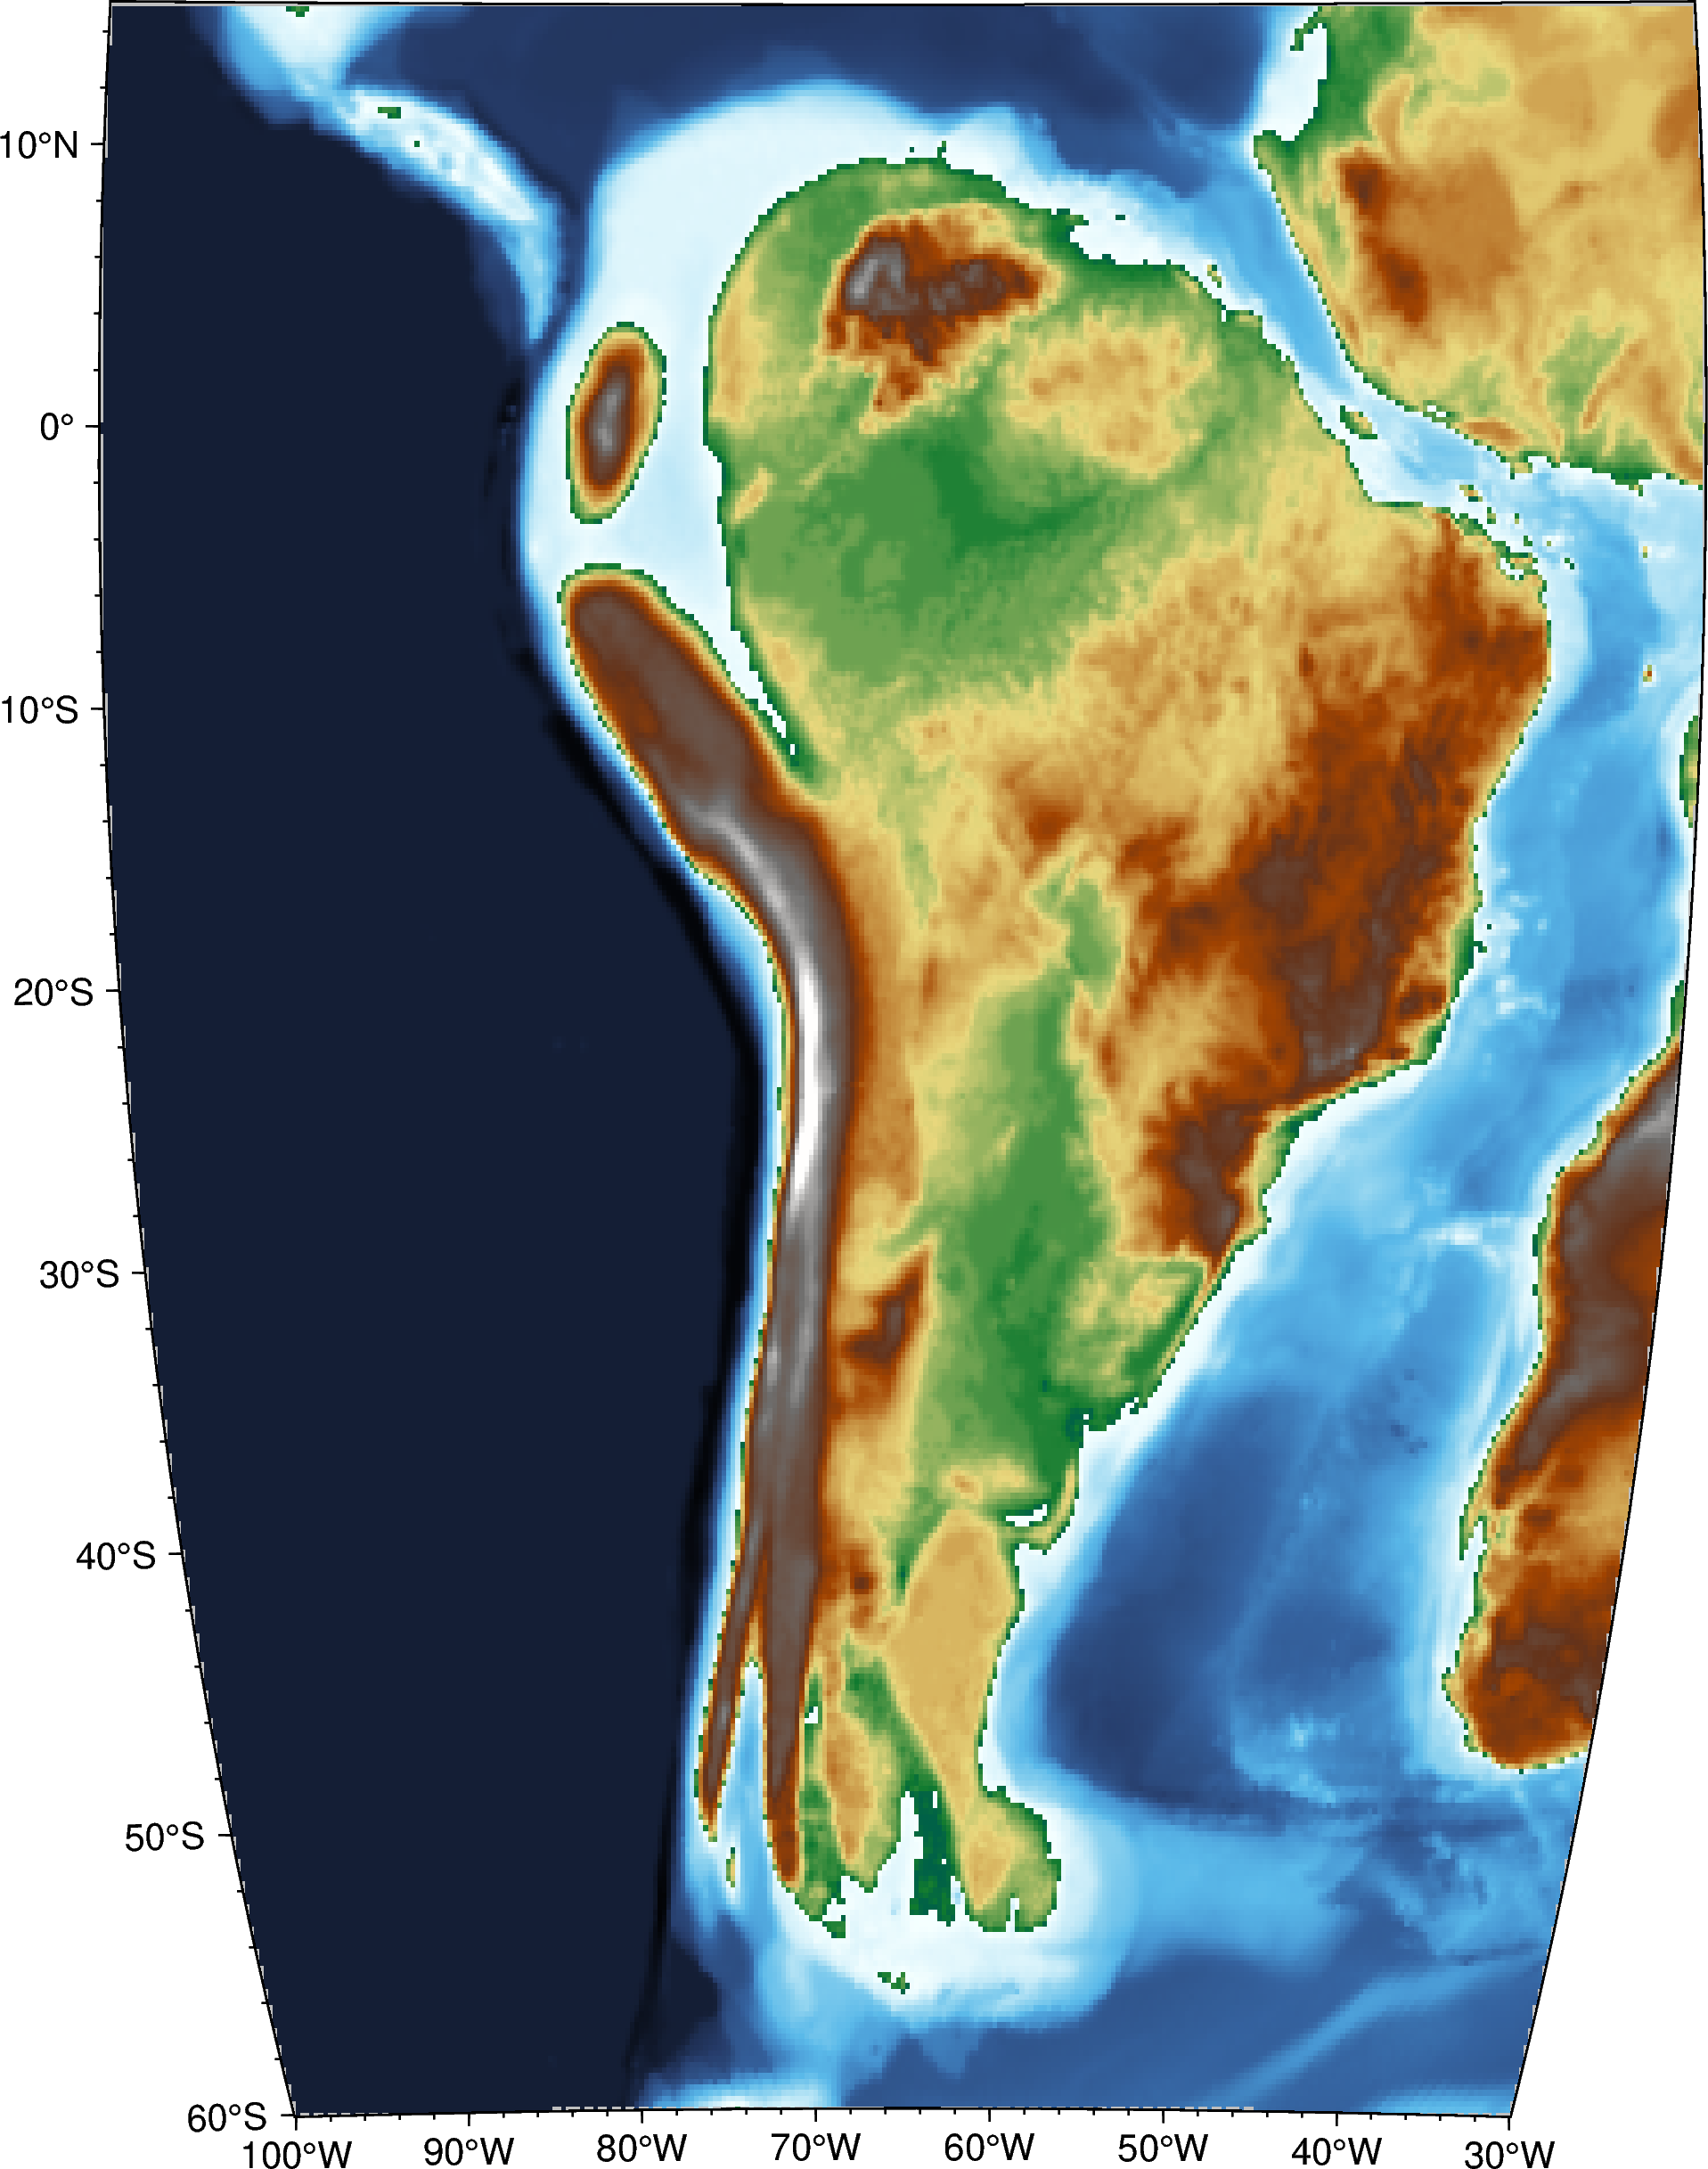

In [4]:
region = [-100,-30,-60,15]
rotated_grid = to_anchor_plate(raster_list[reconstruction_time], 
                               ScoteseModel, 
                               reconstruction_time, 
                               plate_id_to_rotate_to, 
                               region=region, spacing=0.2)

fig = pygmt.Figure()
fig.basemap(projection='R6i', region=region, frame='afg')
fig.grdimage(rotated_grid, cmap='geo')
fig.show()


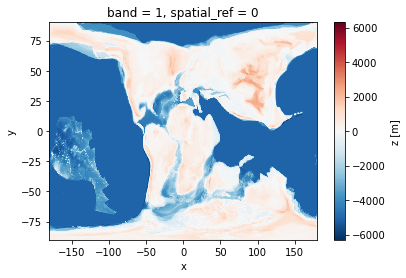

In [27]:
import rioxarray as rio

xds = rio.open_rasterio(raster_list[reconstruction_time])

xds.rio.set_crs("epsg:4326")

xds.plot()

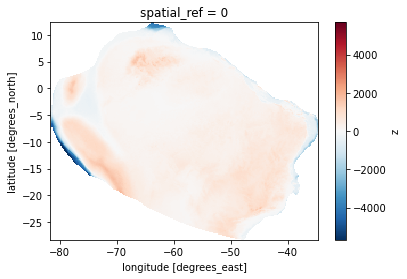

In [87]:
import geopandas as gpd

# the next two lines extract a single polygon from the Scotese model files, specifically
# the polygon with a plateID of 201 (South America)
# The polygon is extracted as a single entry from a geodataframe
gdf = gpd.GeoDataFrame.from_file(ScoteseModel.static_polygon_files[0])
gdf = gdf[gdf.PlateID==201].iloc[0]

# To use the clipping functionality of rioxarray, we need to set some metadato to the grid object 
# specifically the coordinate projection system and the names of the coordinate fields
rotated_grid.rio.set_crs("epsg:4326")
rotated_grid.rio.set_spatial_dims('lon', 'lat')

# Now apply the polygon mask to the rotated grid
# Note here we also specify the crs of the geometries though this is not strictly necessary where the 
# crs is the same as the grid
masked_rotated_grid = rotated_grid.rio.clip([gdf.geometry], crs="epsg:4326")

# Plot the result, showing that the grid
# has been shrunk in size to the required extent
#res.data[res.data>1e10] = np.nan
masked_rotated_grid.plot()

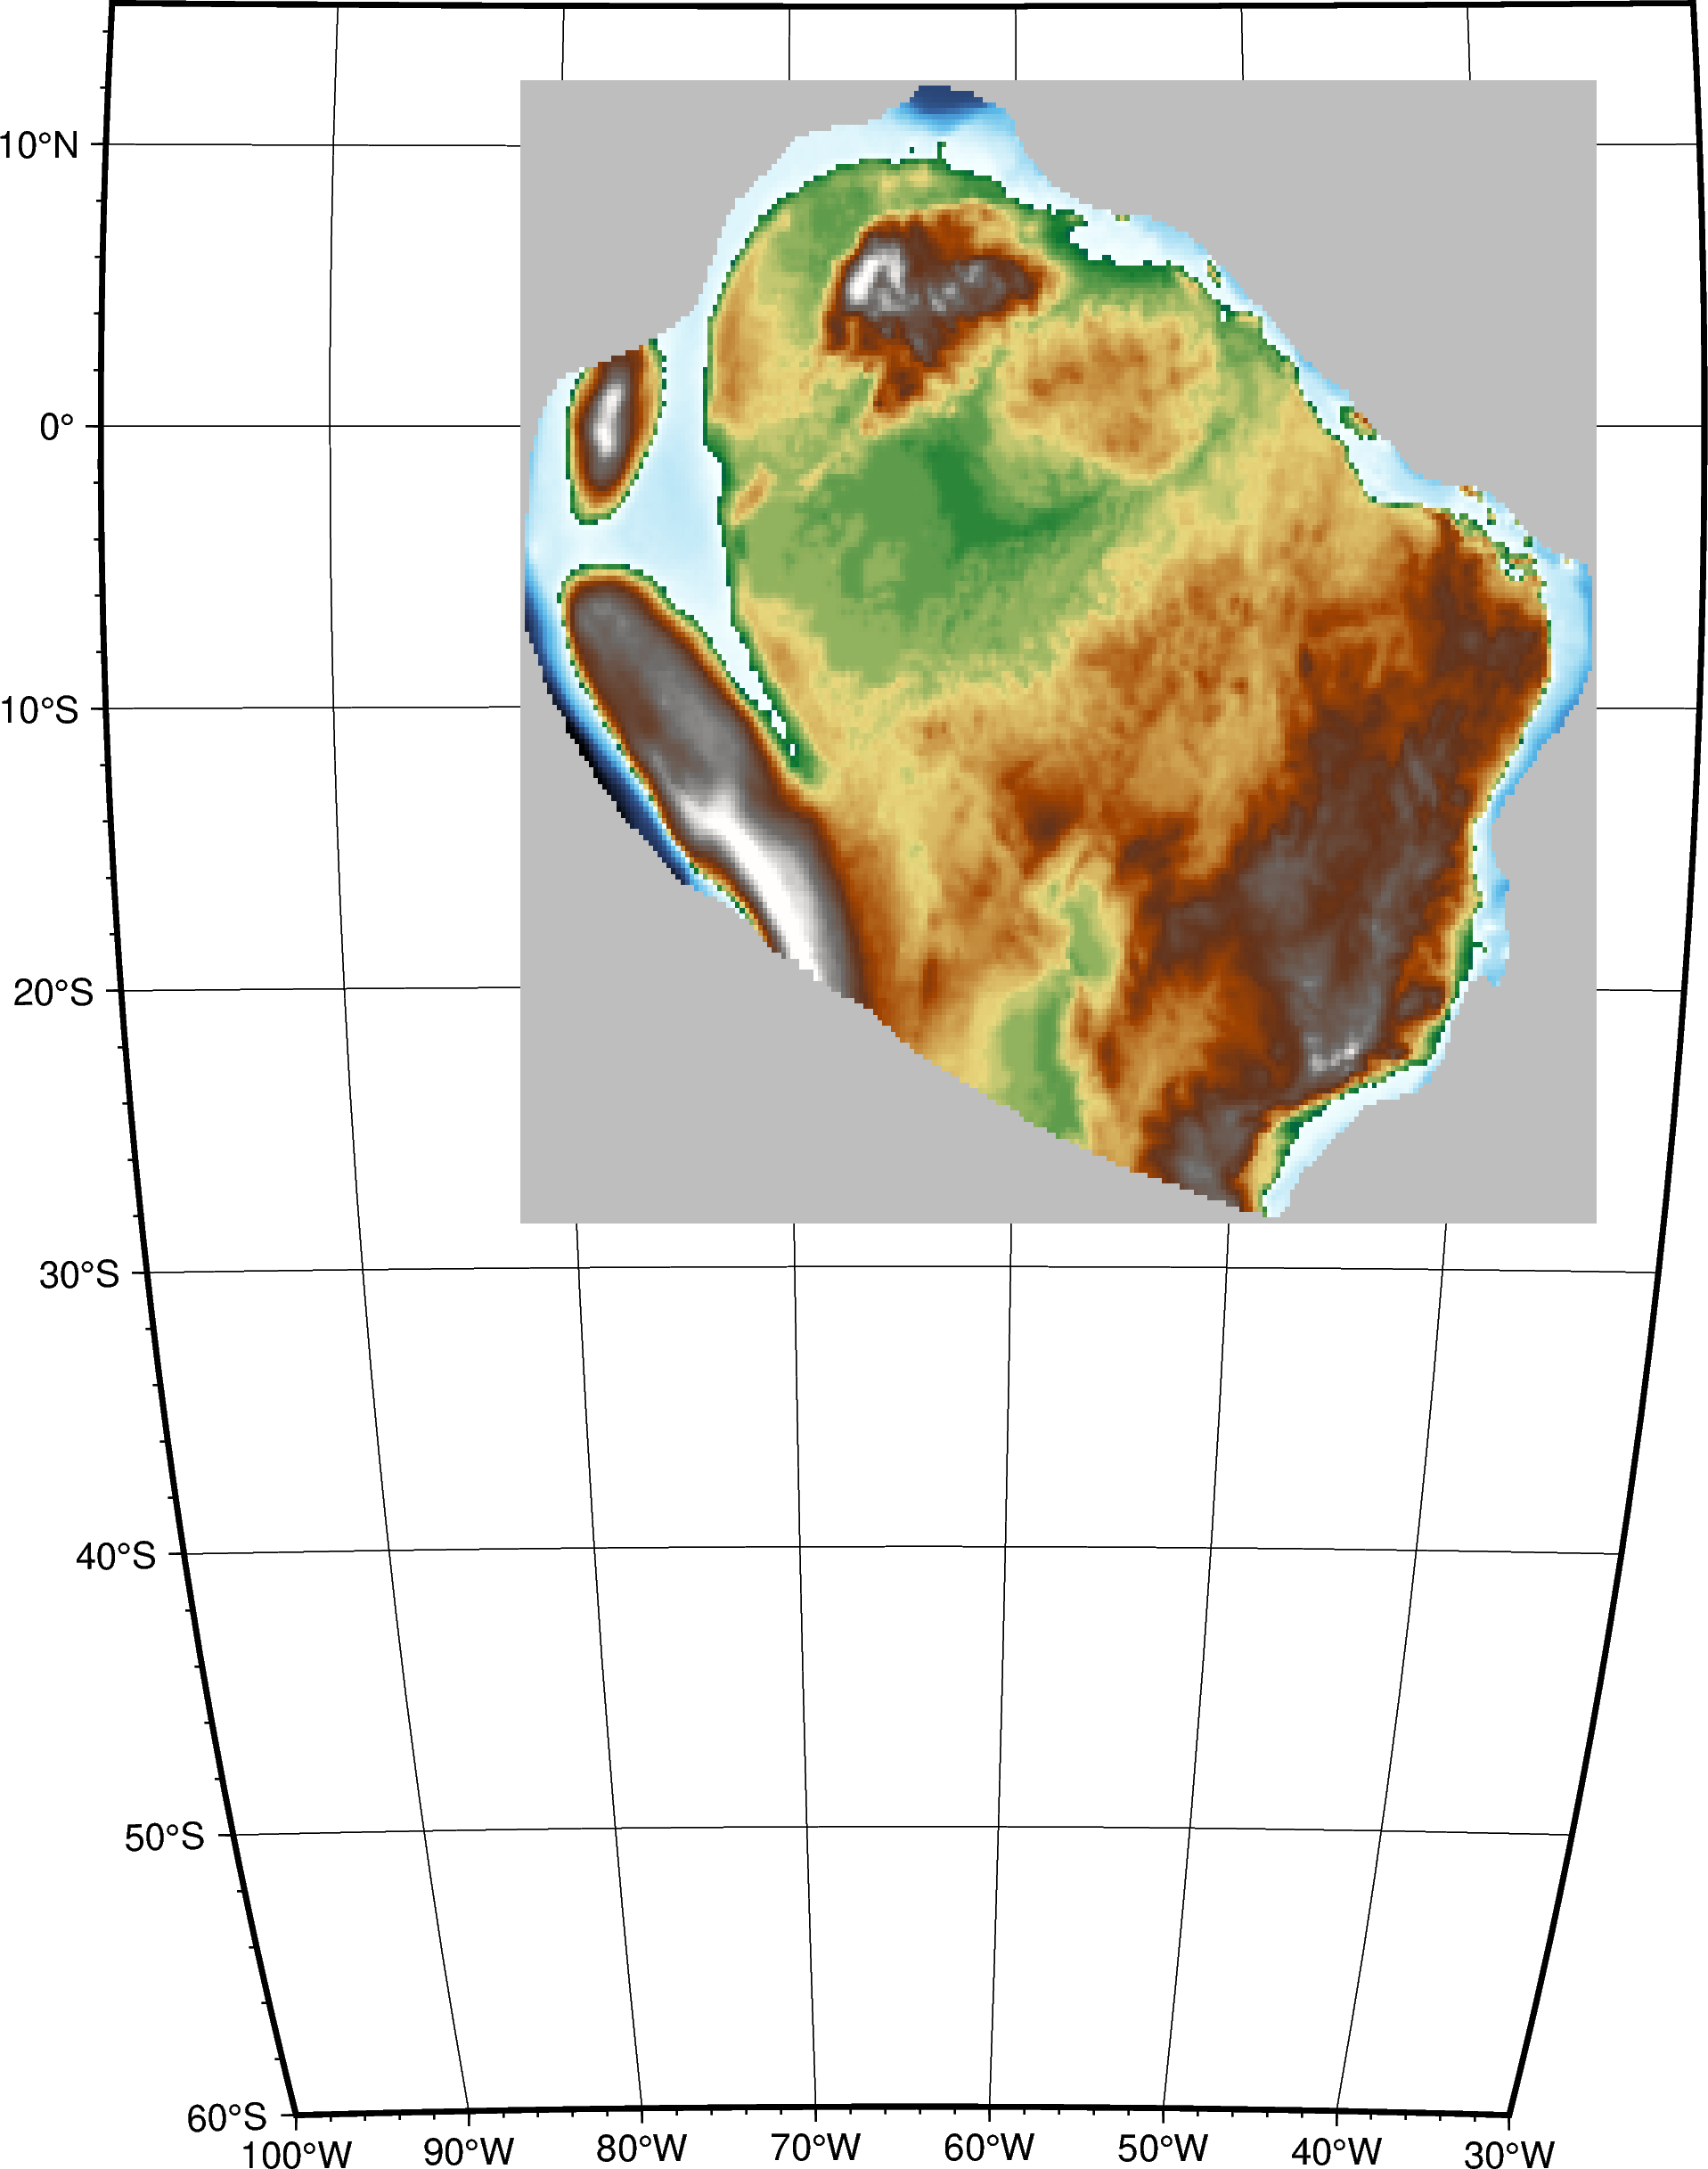

In [88]:
# or plot with pygmt
fig = pygmt.Figure()
fig.basemap(projection='R6i', region=region, frame='afg')
fig.grdimage(masked_rotated_grid, cmap='geo')
fig.show()